<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Load the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler

###Define Functions to Facilitate Metrics Evaluation

In [ ]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [ ]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [ ]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [ ]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

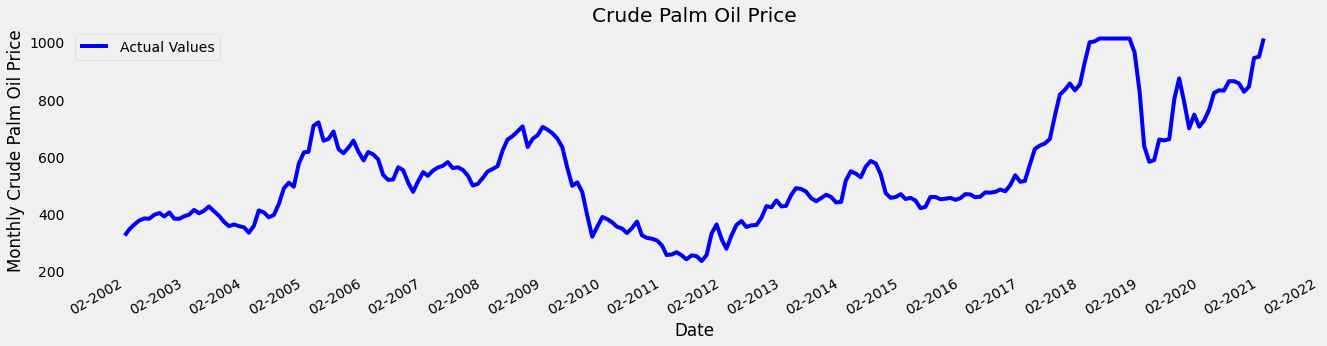

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [ ]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

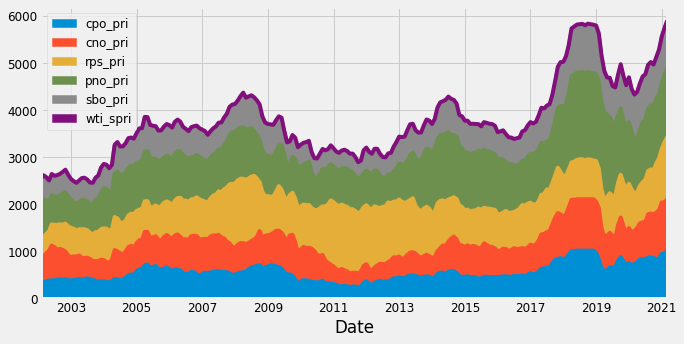

In [ ]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Multilayer Forecasting Technique (MLP)**

###**Split Data into Train Test Segments**

In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 207
Test size: 23


In [ ]:
cols = ['cpo_pri','cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']

scaler = RobustScaler()
scaler = scaler.fit(np.asarray(train[cols]))

train.loc[:, cols] = scaler.transform(np.asarray(train[cols]))
test.loc[:, cols] = scaler.transform(np.asarray(test[cols]))

In [ ]:
cpo_pri_scaler = RobustScaler()
cpo_pri_scaler = cpo_pri_scaler.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_scaler.transform(train[['cpo_pri']])
test['cpo_pri'] = cpo_pri_scaler.transform(test[['cpo_pri']])

In [ ]:
print('Train shape:',train.shape)
print('Test shape:', test.shape)

Train shape: (207, 6)
Test shape: (23, 6)


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 3
# reshape to [samples, time_steps, features]
X_train, y_train = create_dataset(train, train.cpo_pri, time_steps)
X_test, y_test = create_dataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(204, 3, 6) (204,)


In [ ]:
# reshape to [samples, features]
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]

mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(128, input_dim=X_train_mlp.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(1))
mlp_model.compile(loss='mse', optimizer='adam')
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp_history = mlp_model.fit(X_train_mlp, y_train, validation_data=(X_test_mlp, y_test), epochs=50, shuffle=False)

Epoch 1/50
7/7 [==============================] - 2s 92ms/step - loss: 0.5215 - val_loss: 2.1040
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.3580 - val_loss: 1.5338
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.2445 - val_loss: 1.0706
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 0.1644 - val_loss: 0.7198
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.1126 - val_loss: 0.4716
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 0.0832 - val_loss: 0.3108
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 0.0692 - val_loss: 0.2173
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.0641 - val_loss: 0.1682
Epoch 9/50
7/7 [==============================] - 0s 5ms/step - loss: 0.0625 - val_loss: 0.1447
Epoch 10/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0615 - val_loss: 0.1350
Epoch 11/50
7/7 [====================

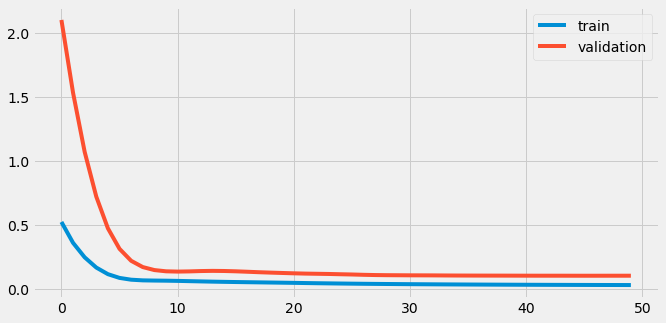

In [ ]:
plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
y_pred = mlp_model.predict(X_test_mlp)
y_train_inv = cpo_pri_scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_scaler.inverse_transform(y_pred)

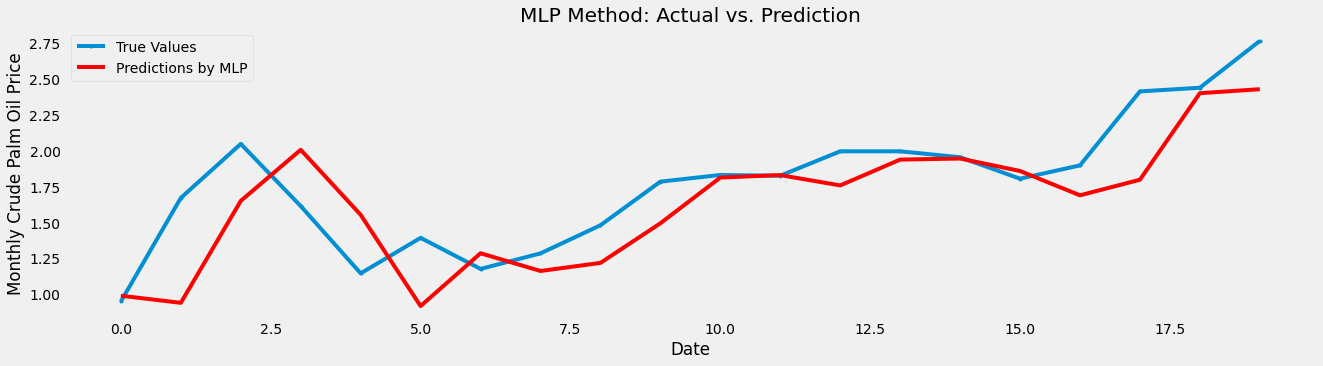

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', label='predicted')
plt.legend(['True Values', 'Predictions by MLP', 'MLP Prediction'],loc='best')
plt.title('MLP Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Model Evaluation

In [ ]:
MAE_mlp = mean_absolute_error(y_test, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_mlp)

MDA_mlp = mda(y_test, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(y_test, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(y_test,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(y_test,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_mlp)

EVS_mlp = explained_variance_score(y_test, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_mlp)

MAE value of the SVR Model is: 0.2397278526448346
MDA value of the SVR Model is: 0.5152354570637119
MAPE value of the SVR Model is: 29.698762619642494
RMSE value of the SVR Model is: 0.31700570519590515
MSE value of the SVR Model is: 0.10049261712675314
EVS score of the MLP Model is: 0.5926166744271177


###**Adjusting Hyperparameters of MLP Regressor to get more perfect performance**
**Hyper Parameter Tuning:**

In [ ]:
mlp = MLPRegressor(max_iter=100)

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(64,64,64), (64,128,64), (128,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [82]:
from sklearn.model_selection import GridSearchCV

mlp_gs = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
mlp_gs.fit(X_train_mlp , np.ravel(y_train))
print('Best parameters found:\n', mlp_gs.best_params_)
mlp_gs.best_score_

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}


0.9106917502876164

In [ ]:
mlp_grid_predictions = mlp_gs.predict(X_train_mlp) 

In [91]:
mlp_model = tf.keras.Sequential()
# Adding the first MLP layer and activation
mlp_model.add(tf.keras.layers.Dense(64, input_dim=X_train_mlp.shape[1], activation='tanh'))
mlp_model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
 # Adding the second MLP layer and initializer
mlp_model.add(tf.keras.layers.Dense(128, kernel_initializer='random_normal'))
 # Adding the third MLP layer and initializer
mlp_model.add(tf.keras.layers.Dense(64, kernel_initializer='random_normal'))
mlp_model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
# Adding the output layer
mlp_model.add(tf.keras.layers.Dense(1))
mlp_model.compile(loss='mse', optimizer='adam')
mlp_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                256       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,897
Trainable params: 16,897
Non-trai

In [92]:
mlp_history = mlp_model.fit(X_train_mlp, y_train, validation_data=(X_test_mlp, y_test), epochs=100, shuffle=False)

Epoch 1/100
7/7 [==============================] - 1s 25ms/step - loss: 0.5461 - val_loss: 1.5641
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2507 - val_loss: 0.5727
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0931 - val_loss: 0.1197
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0872 - val_loss: 0.1637
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0925 - val_loss: 0.1074
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0758 - val_loss: 0.1398
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0626 - val_loss: 0.1205
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0560 - val_loss: 0.0969
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0547 - val_loss: 0.0928
Epoch 10/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0507 - val_loss: 0.0927
Epoch 11/100
7/7 [==========

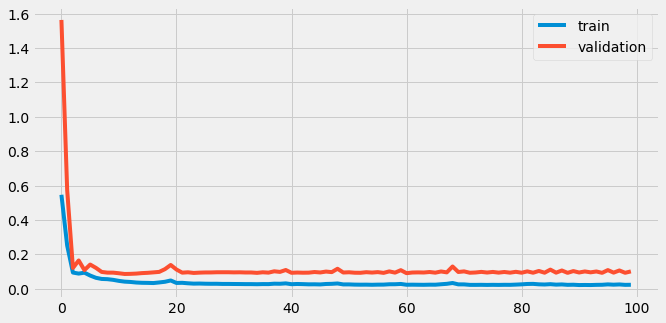

In [93]:
plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [94]:
y_pred = mlp_model.predict(X_test_mlp)
y_train_inv = cpo_pri_scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_scaler.inverse_transform(y_pred)

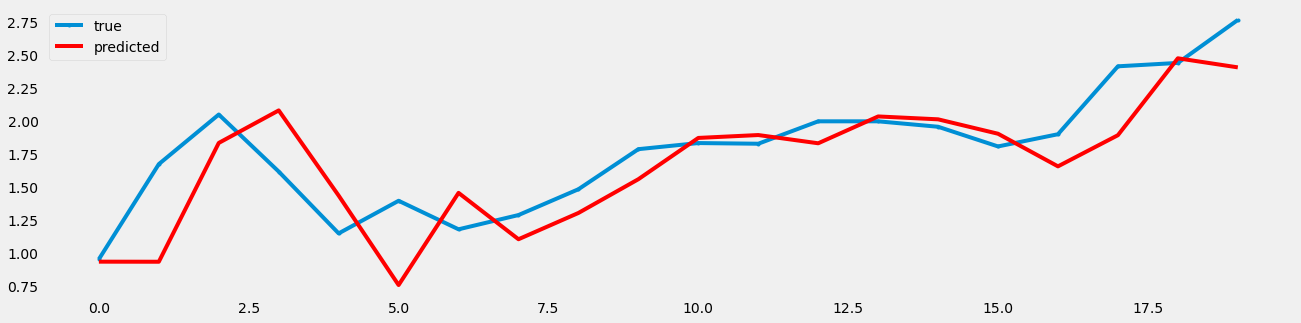

In [95]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', label='predicted')
plt.legend()
plt.show()

In [96]:
MAE_mlp = mean_absolute_error(y_test, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_mlp)

MDA_mlp = mda(y_test, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(y_test, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(y_test,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(y_test,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_mlp)

EVS_mlp = explained_variance_score(y_test, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_mlp)

MAE value of the SVR Model is: 0.2422121011199559
MDA value of the SVR Model is: 0.481994459833795
MAPE value of the SVR Model is: 31.16944727980465
RMSE value of the SVR Model is: 0.31605195350081244
MSE value of the SVR Model is: 0.09988883731167972
EVS score of the MLP Model is: 0.5555194952056414
